# My Tokenizer

In [1]:
import cProfile
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# set up tqdm
try:
    if 'ZMQInteractiveShell' == get_ipython().__class__.__name__:
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm
except NameError:
    from tqdm import tqdm

# config
MAX_VOCAB_SIZE: int = 50_000  # maximum size of vocab
MAX_TOKEN_LEN: int = 40  # maximum length of token
RANDOM_SEED = 42

# don't change these
MAX_ENTROPY = round(float(np.log2(MAX_VOCAB_SIZE)), 2)
ASCII_PUNCTUATION = [bytes([i]) for i in range(32,48)] + [bytes([i]) for i in range(58,65)] + [bytes([i]) for i in range(91,97)] + [bytes([i]) for i in range(123,127)]
ASCII_DIGITS = [bytes([i]) for i in range(48,58)]
ASCII_LOWERCASE = [bytes([i]) for i in range(97,123)]
ASCII_UPPERCASE = [bytes([i]) for i in range(65,91)]
ASCII_CONTROL = [bytes([i]) for i in range(0,32)]
ASCII_OTHER = [bytes([i]) for i in range(127,256)]

## Load dataset

In [2]:
ds_name, data_dir, split = ("graelo/wikipedia", "20230901.en", "train")
#ds_name, data_dir, split = ("wikitext", "wikitext-2-raw-v1", "train")

print(f"Loading dataset...", flush=True)
t0 = time.time()
ds = load_dataset(ds_name, data_dir, split=split)
print(f"Loaded dataset in {time.time() - t0:.1f} seconds", flush=True)

Loading dataset...
Loaded dataset in 4.9 seconds


## Build Vocabulary

In [5]:
class Vocabulary(dict):

    def __init__(self, 
                 *args, 
                 unmergable_tokens=ASCII_PUNCTUATION, #+ASCII_DIGITS, 
                 truncate_freq_lower_bound=2, 
                 max_size=MAX_VOCAB_SIZE,
                 max_token_len=MAX_TOKEN_LEN,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.unmergable_tokens = unmergable_tokens
        self.truncate_freq_lower_bound = truncate_freq_lower_bound
        self.max_size = max_size
        self.max_token_len = max_token_len

        # initialize with all bytes
        self.update({bytes([i]): 0 for i in range(256)})

    def mean(self):
        return np.mean(list(self.values()))

    def std(self):
        return np.std(list(self.values()))

    def sum(self):
        return sum(self.values())
    
    def entropy(self, precision=1):
        #return round(entropy(self.values()), precision)
        s = self.sum()
        if s <= 0:
            return 0
        p = np.array([v/s for v in self.values() if v > 0])
        h = (-p * np.log2(p)).sum()
        return round(h, precision)

    def most_common(self, n=None, reverse=False):
        if n is None:
            n = len(self) + 1
        return sorted(self.items(), key=lambda x: x[1], reverse=not reverse)[:n]

    def sorted_values(self, reverse=False):
        return sorted(list(self.values()), reverse=reverse)

    def truncate(self, freq_lower_bound=None, max_size=None):
        assert len(self) > 256, f"Vocabulary has {len(self)} tokens and cannot be truncated"

        if freq_lower_bound is None:
            freq_lower_bound = self.truncate_freq_lower_bound

        if max_size is None:
            max_size = self.max_size
        
        n_kept_tokens = len([t for t in self.keys() if len(t) == 1])
        for t, f in self.most_common():
            if len(t) == 1:
                continue
            elif (f < freq_lower_bound) or (n_kept_tokens >= max_size):
                del self[t]
            else:
                n_kept_tokens += 1

        assert len(self) > 256, f"Vocabulary truncated down to individual bytes only, trying lowering `freq_lower_bound` or increasing `max_size`"
        assert len(self) <= max_size, f"Vocabulary failed to truncate down to `max_size`={max_size}"
    
    def find_next_token(self, text, threshold=None):
        if threshold is None:
            threshold = self.mean()

        prev_token = None
        prev_freq = None
        for L in range(1, self.max_token_len + 1):
            token = text[:L]
            #if token in self.unmergable_tokens:
            #    return token
            if (len(token) > 1) and token[-1:] in self.unmergable_tokens:
                return prev_token
            if (token in self):
                prev_token = token
                prev_freq = self[token]
            else:
                break

        if (prev_token is None) or (prev_freq > threshold):
            return token
        else:
            return prev_token

    def __repr__(self):
        mc = self.most_common()
        return f"Vocabulary({{{mc[0][0]}: {mc[0][1]}, ..., {mc[-1][0]}: {mc[-1][1]}}})"
        return f"Vocabulary({super().__repr__()})"

    @classmethod
    def create(cls, 
               dataset, 
               unmergable_tokens=ASCII_PUNCTUATION, #+ASCII_DIGITS, 
               truncate_freq_lower_bound=2, 
               max_size=MAX_VOCAB_SIZE,
               max_token_len=MAX_TOKEN_LEN,
               ):

        vocab = cls(unmergable_tokens=unmergable_tokens, 
                    truncate_freq_lower_bound=truncate_freq_lower_bound, 
                    max_size=max_size,
                    max_token_len=max_token_len)

        with tqdm(desc="passes", unit='pass', position=0, leave=True) as pruning_pb:
            with tqdm(desc="n_tokens", total=vocab.max_size, initial=len(vocab), unit="token", position=1, leave=True) as tokens_pb:
                with tqdm(desc=f"entropy", total=MAX_ENTROPY, initial=vocab.entropy(), unit="bit", position=2, leave=True) as entropy_pb:
                    dl = dataset.to_iterable_dataset().shuffle(seed=RANDOM_SEED, buffer_size=10_000)
                    
                    time_stamps = [time.time()]
                    token_freq_log = [vocab.sorted_values()]

                    for ex in dl:
                        if len(vocab) >= vocab.max_size:
                            vocab.truncate()
                            pruning_pb.update(1)
                            tokens_pb.desc="n_tokens"
                            tokens_pb.refresh()
                            if len(vocab) >= vocab.max_size:
                                break

                        text = bytes(ex['text'], 'utf-8')

                        while text:
                            t = vocab.find_next_token(text[:vocab.max_token_len])
                            text = text[len(t):]
                            if t in vocab:
                                vocab[t] += 1
                            else:
                                vocab[t] = 1
                                if len(vocab) % 500 == 0:
                                    time_stamps.append(time.time())
                                    token_freq_log.append(vocab.sorted_values())

                            if len(vocab) > vocab.max_size:
                                tokens_pb.desc="n_tokens (pruning...)"
                                tokens_pb.refresh()
                            else:
                                tokens_pb.n = len(vocab)
                                tokens_pb.refresh()
                                entropy_pb.n = vocab.entropy()
                                entropy_pb.refresh()


        time_stamps.append(time.time())
        token_freq_log.append(vocab.sorted_values())

        return vocab, time_stamps, token_freq_log


In [7]:
#cProfile.run('vocab, time_stamps, token_freq_log = Vocabulary.create()')
vocab, time_stamps, token_freq_log = Vocabulary.create(ds, unmergable_tokens=[]) 


passes: 0pass [00:00, ?pass/s]

n_tokens:   1%|          | 256/50000 [00:00<?, ?token/s]

entropy:   0%|          | 0/15.61 [00:00<?, ?bit/s]

In [ ]:
vocab.most_common()

### save vocab

In [ ]:
import csv
with open("vocab.csv", 'w') as f:
    writer = csv.DictWriter(f, fieldnames=['id', 'token', 'frequency'])
    writer.writeheader()
    for i, (t, fr) in enumerate(vocab.most_common()):
        writer.writerow({'id':i, 'token': t, 'frequency':fr})

with open("vocab.csv", 'r') as f:
    reader = csv.DictReader(f)
    test_loaded_vocab = Counter({eval(r['token']): int(r['frequency']) for r in reader})

assert vocab.items() == test_loaded_vocab.items(), f"ERROR:\n{vocab.items()=}\n{test_loaded_vocab.items()=}"

## Visualization

In [9]:
def entropy(x):
    s = sum(x)
    if s > 0:
        p = np.array(x) / s
        h = -p * np.log2(p)
        h = np.nan_to_num(h).sum()
    else:
        h = 0
    return h


reading data:   0%|          | 0/677 [00:00<?, ?frame/s]

/var/folders/xs/tqnvbbfn7dg26mmpnqp49fh80000gr/T/ipykernel_33918/3644461046.py:79: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.ax.set_yscale('log')
/var/folders/xs/tqnvbbfn7dg26mmpnqp49fh80000gr/T/ipykernel_33918/3644461046.py:91: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  self.ax.set_xlim(self.xmin_min,self.xmax_max)
/var/folders/xs/tqnvbbfn7dg26mmpnqp49fh80000gr/T/ipykernel_33918/3644461046.py:98: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  self.ax.set_ylim(ymin, max(y))
/var/folders/xs/tqnvbbfn7dg26mmpnqp49fh80000gr/T/ipykernel_33918/3644461046.py:91: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  self.ax.set_xlim(self.xmin_min,self.xmax_max)
/var/folders/xs/tqnvbbfn7dg26mmpnqp49fh80000gr/T/ipykernel_33918/3644461046.py:98: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  self.ax.set_

reading data:   0%|          | 0/677 [00:00<?, ?frame/s]

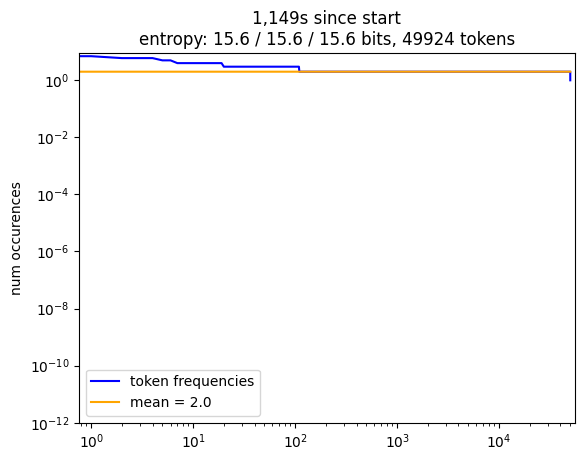

In [18]:
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
import matplotlib.animation as animation


class Animated(object):
    def __init__(self, time_stamps, token_freq_log, frame_rate, log_xscale=False, log_yscale=True, fixed_ylim=True, fixed_xlim=True, normalized=True):
        if token_freq_log and (max(token_freq_log[0]) == 0):
            self.time_stamps, self.token_freq_log = time_stamps[1:], token_freq_log[1:]
        else:
            self.time_stamps, self.token_freq_log = time_stamps, token_freq_log
        self.frame_rate = frame_rate
        self.log_xscale = log_xscale
        self.log_yscale = log_yscale
        self.fixed_xlim = fixed_xlim
        self.fixed_ylim = fixed_ylim
        self.normalized = normalized
        self.t0 = time_stamps[0]
        self.stream = self.data_stream()

        if self.log_yscale or self.log_xscale:
            _, xs, ys = zip(*list(self.data_stream()))
            xs = sum([x.tolist() for x in xs], [])
            ys = sum([y.tolist() for y in ys], [])
            self.xmax_max = max(xs)
            self.xmin_min = min(xs)
            self.ymax_max = max(ys)
            self.ymin_min = min(ys)

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=200, 
                                          init_func=self.setup_plot, save_count=len(self.time_stamps), blit=True) # init_func=self.update, 

    def data_stream(self):
        d = zip(self.time_stamps, self.token_freq_log)
        for raw_t, raw_freqs in tqdm(d, total=len(self.time_stamps), desc="reading data", unit="frame"):
            t = round(raw_t - self.t0)
            freqs = np.array(sorted(raw_freqs, reverse=True))
            freqs = freqs[freqs > 0]
            if self.normalized:
                freqs = freqs / freqs.sum()
            x = np.arange(len(freqs))
            yield t, x, freqs

    def setup_plot(self):
        return self._render()

    def update(self, i=0):
        try:
            t, x, y = next(self.stream)
        except StopIteration:
            return []
        return self._render(t=t, x=x, y=y)

    def _render(self, t=None, y=None, x=None):
        for line in self.ax.lines:
            line.remove()

        if t is None:
            t = 0
        if y is None:
            y = sorted(token_freq_log[0], reverse=True)
        if x is None:
            x = np.arange(len(y))

        m = np.mean(y)

        plots = self.ax.plot(x, y, color="blue", label=f'token frequencies')
        plots += self.ax.plot(x, [m] * len(x), color="orange", label=f'mean = {m:,.1f}')

        self.ax.set_title(f"{int(t):,}s since start" + \
                          f"\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {MAX_ENTROPY:.01f} bits" + \
                          f", {len(y)} tokens")
        #self.ax.set_xlabel('token id')
        self.ax.set_ylabel('num occurences')
        
        if self.log_yscale:
            self.ax.set_yscale('log')
            ymin = min([v for v in y if v > 0] + [1e-12])
        else:
            ymin = min(y)

        if self.log_xscale:
            self.ax.set_xscale('log')
            xmin = min([v for v in x if v > 0] + [1e-12])
        else:
            xmin = min(x)

        if self.fixed_xlim:
            self.ax.set_xlim(self.xmin_min,self.xmax_max)
        else:
            self.ax.set_xlim(xmin, max(x))

        if self.fixed_ylim:
            self.ax.set_ylim(self.ymin_min, self.ymax_max)
        else:
            self.ax.set_ylim(ymin, max(y))
        
        self.ax.legend()
        
        return plots



framerate = 8
a = Animated(time_stamps, token_freq_log, framerate, log_xscale=True, fixed_ylim=False, normalized=False)
#plt.show()
a.ani.save('test.mp4', fps=framerate, extra_args=['-vcodec', 'libx264'])
#a.ani.save('test.gif', fps=30)


In [15]:
max(token_freq_log[-1])

9